In [1]:
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Обозначения

- 0 - rock (камень)

- 1 - paper (бумага)
 
- 2 - scissors (ножницы)

In [2]:
# Задаем количество игр.
env = make(
    "rps", 
    configuration={"episodeSteps": 100}
)

### Пишем первого агента, который всегда выбирает только камень и сохраняем результат.

In [3]:
%%writefile rock_agent.py
def rock_agent(observation, configuration):
    return 0

Writing rock_agent.py


### Пишем второго агента, который всегда выбирает только бумагу.

In [4]:
%%writefile paper_agent.py
def paper_agent(observation, configuration):
    return 1

Writing paper_agent.py


### Пишем третьего агента, который всегда выбирает только ножницы.

In [5]:
%%writefile scissors_agent.py
def scissors_agent(observation, configuration):
    return 2

Writing scissors_agent.py


### Пишем четвертого агента, который всегда копирует последний ход оппонента.

In [6]:
%%writefile copy_opponent_agent.py

import random
def copy_opponent_agent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent_agent.py


### Пишем пятого агента, который выкидывает случайно 1 из предложенных действий.

In [7]:
%%writefile reactionary_agent.py

import random
import math

def get_score(left_move, right_move):
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_react_action

Writing reactionary_agent.py


### Пишем шестого агента.

In [8]:
%%writefile counter_reactionary_agent.py

import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary_agent(observation, configuration):
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs

    return last_counter_action

Writing counter_reactionary_agent.py


### Пишем седьмого агента.

In [9]:
%%writefile statistical_agent.py

import random
action_histogram = {}
def statistical_agent(observation, configuration):
    global action_histogram
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    for k, v in action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue

    return (mode_action + 1) % configuration.signs

Writing statistical_agent.py


### Пишем восьмого агента.

In [10]:
%%writefile Jonson_agent.py

import numpy as np
import collections
def Jonson_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 25 == 0: # обновляем таблицу каждые 25 шагов. 
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])    
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # вносим изменения
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # вносим изменения последовательности действий
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # предсказание следующего хода опонента
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 50:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())
    # совершаем действия
    action = (next_opponent_action_pred + 1) % 3
    # меняем стратегию, если высок шанс проигрыша
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing Jonson_agent.py


### Пишем девятого агента. 

In [11]:
%%writefile nash_equilibrium_agent.py
import random

def nash_equilibrium_agent(observation, configuration):
    return random.randint(0, 2)

Writing nash_equilibrium_agent.py


### Пишем десятого агента

In [12]:
%%writefile rock_paper_agent.py

import random

def rock_paper_agent(observation, configuration):
    return random.randint(0, 1)

Writing rock_paper_agent.py


### Пишем одиннацатого агента.

In [13]:
%%writefile paper_scissors_agent.py

import random

def paper_scissors_agent(observation, configuration):
    return random.randint(1, 2)

Writing paper_scissors_agent.py


### Пишем двенадцатого агента.

In [14]:
%%writefile rock_scissors_agent.py

import random

def rock_scissors_agent(observation, configuration):
    return random.randint(0, 2)

Writing rock_scissors_agent.py


### Пишем тринадцатого агента

In [15]:
%%writefile transition_agent.py

import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def transition_agent(observation, configuration):
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice(
                [0, 1, 2],
                p=P[a1, :]
            ) + 1) % 3)
        else:
            return int(np.random.randint(3))
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Writing transition_agent.py


In [16]:
'''
Наших агентов мы сохраняем в список.
'''
agents = ['rock_agent', 'paper_agent', 'scissors_agent'
         ,'copy_opponent_agent','reactionary_agent' 
         ,'counter_reactionary_agent','statistical_agent'
         ,'Jonson_agent', 'nash_equilibrium_agent'
         ,'rock_paper_agent', 'paper_scissors_agent'
         ,'rock_scissors_agent','transition_agent']

In [17]:
# ко всем агентам из списка добавим расширение .py
agents_py = [i + ".py" for i in agents]
agents_py

['rock_agent.py',
 'paper_agent.py',
 'scissors_agent.py',
 'copy_opponent_agent.py',
 'reactionary_agent.py',
 'counter_reactionary_agent.py',
 'statistical_agent.py',
 'Jonson_agent.py',
 'nash_equilibrium_agent.py',
 'rock_paper_agent.py',
 'paper_scissors_agent.py',
 'rock_scissors_agent.py',
 'transition_agent.py']

In [18]:
n_agents = len(agents)
scores = np.zeros((n_agents, n_agents))

In [19]:
scoresOverTime = {}
for opp in agents:
    scoresOverTime[opp] = []

scoresOverTime

{'rock_agent': [],
 'paper_agent': [],
 'scissors_agent': [],
 'copy_opponent_agent': [],
 'reactionary_agent': [],
 'counter_reactionary_agent': [],
 'statistical_agent': [],
 'Jonson_agent': [],
 'nash_equilibrium_agent': [],
 'rock_paper_agent': [],
 'paper_scissors_agent': [],
 'rock_scissors_agent': [],
 'transition_agent': []}

In [20]:
for i in range(n_agents):
    for j in range(i + 1, n_agents):
        
        result = evaluate(
            "rps", 
            [agents_py[i], agents_py[j]], 
            configuration={"episodeSteps": 100},
            num_episodes = 1
            )
        
        scores[i, j] = result[0][0]
        scores[j, i] = result[0][1]

## Строим матрицу корреляций. 

In [21]:
#создам DataFrame и отдельно выведу все наши фичи.
df_scores = pd.DataFrame(scores, index=agents, columns=agents)
columns = df_scores.columns

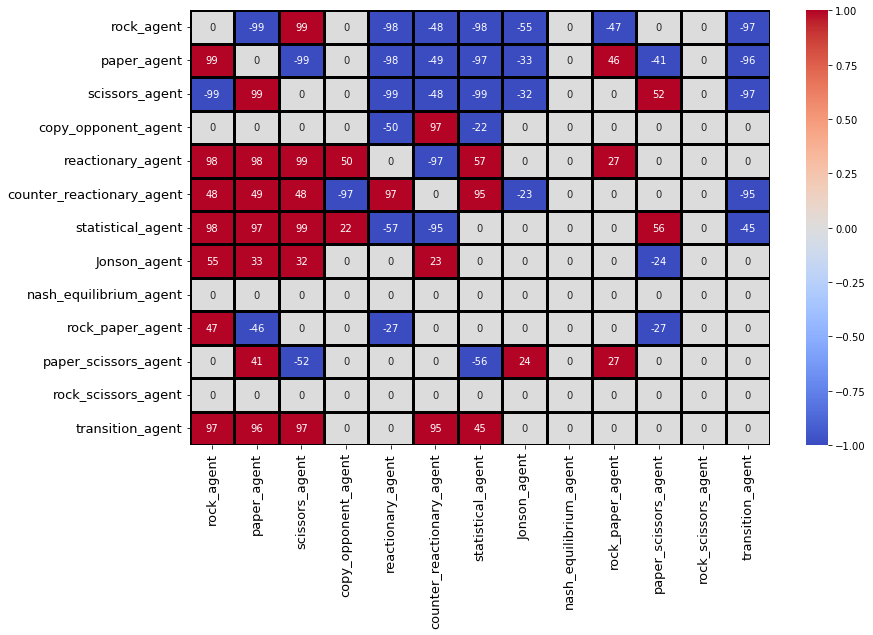

In [22]:
plt.figure(figsize=(13, 8))
sns.heatmap(df_scores, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13);

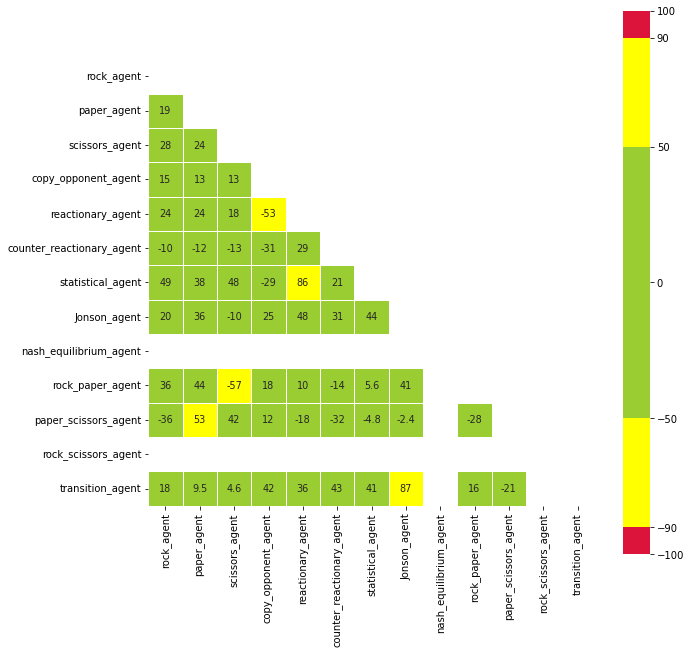

In [23]:
# На мой взгляд более информативно будет построить подобную схему, чем heatmap
import math
from matplotlib.colors import LinearSegmentedColormap

cmatrix = df_scores[columns].corr() * 100
    
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'yellow', 'yellow', 'yellow',
                                                             'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen',
                                                             'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen', 'yellowgreen',
                                                             'yellow', 'yellow', 'yellow', 'yellow', 'crimson'], 20)

mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(ax=ax, data=cmatrix, cmap=cmap, 
                vmin=-100, vmax=100, linewidths=.5, 
                square=True, annot=True, 
                mask=mask, annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-100, -90, -50, 0, 50, 90, 100])
plt.show()

### Проведем несколько экспериментов на заданном количестве игр

In [24]:
env.run(
    ["Jonson_agent.py", "rock_agent.py"]
)

env.render(mode="ipython", width=500, height=400)

In [25]:
evaluate(
    "rps", 
    ["Jonson_agent.py", "rock_agent.py"], 
    configuration={"episodeSteps": 1000}
)

[[36.0, -36.0]]

In [26]:
env.run(
    ["copy_opponent_agent.py", "Jonson_agent.py"]
)

env.render(mode="ipython", width=500, height=400)

In [27]:
evaluate(
    "rps", 
    ["copy_opponent_agent.py", "Jonson_agent.py"], 
    configuration={"episodeSteps": 1000}
)

[[-35.0, 35.0]]

In [28]:
env.run(
    ["nash_equilibrium_agent.py", "Jonson_agent.py"]
)

env.render(mode="ipython", width=500, height=400)

In [29]:
evaluate(
    "rps", 
    ["nash_equilibrium_agent.py", "Jonson_agent.py"], 
    configuration={"episodeSteps": 1000}
)

[[0, 0]]